In [43]:
# ==============================
# 1) Import thư viện
# ==============================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import nltk

from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS as WC_STOPWORDS
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
from scipy.stats import randint, uniform
from sklearn.decomposition import TruncatedSVD
import sys, os
sys.path.append(os.path.abspath("../.."))
from src.preprocessing import preprocess_text_fin

In [44]:
# ==============================
# 2) Cấu hình chung
# ==============================
DATA_PATH = "../../data/data.csv"     # thay bằng đường dẫn thực tế
TEXT_COL = "Sentence"
TARGET_COL = "Sentiment"

TEST_SIZE = 0.20
RANDOM_STATE = 42
N_SPLITS = 5

# ==============================
# 2) Load & tiền xử lý dữ liệu
# ==============================
df = pd.read_csv(DATA_PATH)
df["text_clean"] = df[TEXT_COL].apply(preprocess_text_fin)

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df[TARGET_COL],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_COL],
)

In [45]:

# ==============================
# 3A) Pipeline & GridSearchCV - RandomForest (không SVD)
# ==============================
pipe_rf = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                max_df=0.95,
                min_df=5,
                max_features=10_000,
                sublinear_tf=True,
                norm="l2",
            ),
        ),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=400,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
        ),
    ]
)

In [57]:
param_grid_rf = {
    "tfidf__ngram_range": [(1,1), (1,2)],           # (1,2) thường tốt với dữ liệu ngắn tài chính
    "tfidf__min_df": [2, 5],                        # tránh min_df = 1 nếu nhiều từ hiếm
    "tfidf__max_df": [0.85, 0.9, 0.95],             # loại bỏ từ quá phổ biến
    "tfidf__max_features": [5_000, 10_000],         # với ~5.8k câu, 5k-10k thường đủ
    "tfidf__sublinear_tf": [True],                  # để giảm bias từ từ hay lặp
    "tfidf__norm": ["l2", None],                    # thường l2 tốt cho phân lớp

    # "clf__n_estimators": [300, 500],
    # "clf__max_depth": [None, 30],
    # "clf__max_features": ["sqrt", "log2"],   # bỏ 0.2 để tránh lỗi phiên bản
    # "clf__min_samples_split": [2, 5],
    # "clf__min_samples_leaf": [1, 2],
    "clf__bootstrap": [True],
    # Nếu dữ liệu lệch lớp, có thể thử:
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)


In [58]:
# ==============================
# 4A) Train + Evaluate
# ==============================
gs_rf.fit(X_train, y_train)



best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

In [50]:
print("Best params (RF):", gs_rf.best_params_)
print("CV best f1_macro (RF):", gs_rf.best_score_)
print("\n=== Test Accuracy (RF):", accuracy_score(y_test, y_pred_rf))
print("=== Test Macro-F1 (RF):", f1_score(y_test, y_pred_rf, average="macro"))
print("\nClassification Report (RF):\n", classification_report(y_test, y_pred_rf))

Best params (RF): {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': None, 'tfidf__sublinear_tf': True}
CV best f1_macro (RF): 0.5651145518504069

=== Test Accuracy (RF): 0.6629597946963216
=== Test Macro-F1 (RF): 0.5579926310232185

Classification Report (RF):
               precision    recall  f1-score   support

    negative       0.24      0.20      0.22       172
     neutral       0.70      0.79      0.74       626
    positive       0.77      0.66      0.71       371

    accuracy                           0.66      1169
   macro avg       0.57      0.55      0.56      1169
weighted avg       0.65      0.66      0.66      1169



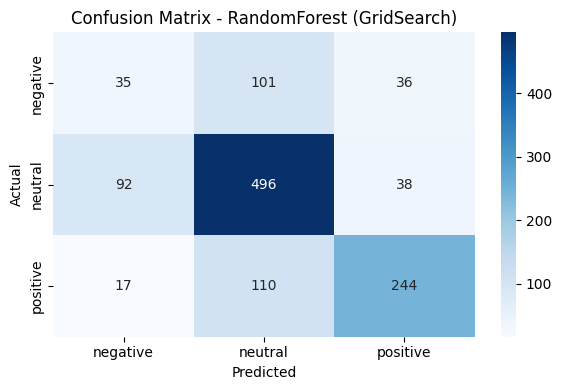

In [48]:
# ==============================
# 5A) Confusion Matrix
# ==============================
classes_rf = best_rf.named_steps["clf"].classes_
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=classes_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_rf, yticklabels=classes_rf)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest (GridSearch)")
plt.tight_layout()
plt.show()

In [ ]:
# ==============================
# 6A) Top feature importance (nếu không dùng SVD)
# ==============================
tfidf = best_rf.named_steps["tfidf"]
clf = best_rf.named_steps["clf"]
feature_names = np.array(tfidf.get_feature_names_out())
importances = clf.feature_importances_

topk = 20
top_idx = np.argsort(importances)[-topk:][::-1]
print("\nTop features by importance (RF):")
for i in top_idx:
    print(f"{feature_names[i]}: {importances[i]:.6f}")

# ==============================
# 7A) Thử nghiệm với nhiều chuỗi
# ==============================
test_sentences = [
    "Dollar falls as traders bet on more rate cuts",
    "Central Europe's FX to get dollar boost, but forint likely to fall from highs",
    "Bulgaria sets price controls as euro transition nears",
    "To make economies work for everyone, we need to put a price on social impact",
    "European shares settle lower as investors gauge mixed earnings, EU-US trade progress",
    "What's in the EU's countermeasures to US tariffs?",
    "Syria is secretly reshaping its economy. The president’s brother is in charge."
]

test_clean_list = [preprocess_text_fin(s) for s in test_sentences]
pred_labels = best_rf.predict(test_clean_list)

# RF có predict_proba
pred_probas = best_rf.predict_proba(test_clean_list)

for i, (raw, clean, pred, probs) in enumerate(zip(test_sentences, test_clean_list, pred_labels, pred_probas), start=1):
    print(f"\n[{i}] Chuỗi gốc: {raw}")
    print(f"    Đã làm sạch: {clean}")
    print(f"    Nhãn dự đoán: {pred}")
    topk = min(3, len(classes_rf))
    top_idx = np.argsort(probs)[-topk:][::-1]
    print("    Top xác suất:")
    for j in top_idx:
        print(f"      - {classes_rf[j]}: {probs[j]:.4f}")





Top features by importance (RF):
currency: 0.038003
decreased: 0.007324
rose: 0.007251
will: 0.007169
lower: 0.006894
increase: 0.006108
fall: 0.005950
increased: 0.005865
buy: 0.005832
short: 0.005786
eur: 0.005231
profit: 0.005225
long: 0.005129
sale: 0.004910
signed: 0.004479
cut: 0.004350
year: 0.004301
fell: 0.004294
positive: 0.004285
loss: 0.004117

[1] Chuỗi gốc: Dollar falls as traders bet on more rate cuts
    Đã làm sạch: dollar fall trader bet rate cut
    Nhãn dự đoán: negative
    Top xác suất:
      - negative: 0.6803
      - neutral: 0.2797
      - positive: 0.0400

[2] Chuỗi gốc: Central Europe's FX to get dollar boost, but forint likely to fall from highs
    Đã làm sạch: central europe fx dollar boost, forint likely fall high
    Nhãn dự đoán: negative
    Top xác suất:
      - negative: 0.6670
      - neutral: 0.1905
      - positive: 0.1425

[3] Chuỗi gốc: Bulgaria sets price controls as euro transition nears
    Đã làm sạch: bulgaria set price control euro transi

In [56]:
# ==============================
# 8A) Lưu model
# ==============================
import pickle, os
os.makedirs("../../models/RandomForest", exist_ok=True)
with open("../../models/RandomForest/rf_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)
print("✅ Đã lưu model RF vào ../../models/RandomForest/rf_model.pkl")

✅ Đã lưu model RF vào ../../models/RandomForest/rf_model.pkl
